# Access data from the NECOFS (New England Coastal Ocean Forecast System) via OPeNDAP

Demonstration using the NetCDF4-Python library to access velocity data from a triangular grid ocean model (FVCOM) via OPeNDAP, specifying the desired URL, time, layer and lat/lon region of interest.  The resulting plot of forecast velocity vectors over color-shaded bathymetry is useful for a variety of recreational and scientific purposes. 

NECOFS (Northeastern Coastal Ocean Forecast System) is run by groups at the University of Massachusetts Dartmouth and the Woods Hole Oceanographic Institution, led by Drs. C. Chen, R. C. Beardsley, G. Cowles and B. Rothschild. Funding is provided to run the model by the NOAA-led Integrated Ocean Observing System and the State of Massachusetts.

NECOFS is a coupled numerical model that uses nested weather models, a coastal ocean circulation model, and a wave model. The ocean model is a volume-mesh model with horizontal resolution that is finer in complicated regions. It is layered (not depth-averaged) and includes the effects of tides, winds, and varying water densities caused by temperature and salinity changes.

* Model description: http://fvcom.smast.umassd.edu/research_projects/NECOFS/model_system.html
* THREDDS server with other forecast and archive products: http://www.smast.umassd.edu:8080/thredds/catalog.html

In [19]:
from pylab import *
%matplotlib inline
import matplotlib.tri as Tri
import netCDF4
import datetime as dt

In [20]:
# DAP Data URL
# MassBay GRID for Boston Harbor, Cape Ann
url = 'http://www.smast.umassd.edu:8080/thredds/dodsC/FVCOM/NECOFS/Forecasts/NECOFS_FVCOM_OCEAN_MASSBAY_FORECAST.nc'
# GOM3 GRID (for Naragansett Bay, Woods Hole)
# url='http://www.smast.umassd.edu:8080/thredds/dodsC/FVCOM/NECOFS/Forecasts/NECOFS_GOM3_FORECAST.nc'
# Open DAP
nc = netCDF4.Dataset(url).variables
nc.keys()

[u'x',
 u'y',
 u'lon',
 u'lat',
 u'xc',
 u'yc',
 u'lonc',
 u'latc',
 u'siglay',
 u'h',
 u'nv',
 u'time',
 u'Times',
 u'zeta',
 u'nbe',
 u'aw0',
 u'awx',
 u'awy',
 u'u',
 u'v',
 u'ww',
 u'ua',
 u'va',
 u'temp',
 u'salinity',
 u'fvcom_mesh']

In [21]:
# take a look at the "metadata" for the variable "u"
print nc['u']

<type 'netCDF4._netCDF4.Variable'>
float32 u(time, siglay, nele)
    long_name: Eastward Water Velocity
    units: meters s-1
    grid: fvcom_grid
    type: data
    missing_value: -999.0
    field: ua, scalar
    coverage_content_type: modelResult
    standard_name: eastward_sea_water_velocity
    coordinates: time siglay latc lonc
    mesh: fvcom_mesh
    location: face
unlimited dimensions: time
current shape = (145, 10, 165095)
filling off



In [22]:
shape(nc['temp'])

(145, 10, 98432)

In [23]:
shape(nc['nv'])

(3, 165095)

In [24]:
# Desired time for snapshot
# ....right now (or some number of hours from now) ...
#start = dt.datetime.utcnow() + dt.timedelta(hours=18)
# ... or specific time (UTC)
start = dt.datetime(2015,7,25,13,0,0)+dt.timedelta(hours=0-5)

In [25]:
# Get desired time step  
time_var = nc['time']
itime = netCDF4.date2index(start,time_var,select='nearest')

# Get lon,lat coordinates for nodes (depth)
lat = nc['lat'][:]
lon = nc['lon'][:]
# Get lon,lat coordinates for cell centers (depth)
latc = nc['latc'][:]
lonc = nc['lonc'][:]
# Get Connectivity array
nv = nc['nv'][:].T - 1 
# Get depth
h = nc['h'][:]  # depth 

In [26]:
dtime = netCDF4.num2date(time_var[itime],time_var.units)
daystr = dtime.strftime('%Y-%b-%d %H:%M')
print daystr

2015-Jul-22 00:00


In [27]:
tri = Tri.Triangulation(lon,lat, triangles=nv)

In [28]:
# get current at layer [0 = surface, -1 = bottom]
ilayer = 0
u = nc['u'][itime, ilayer, :]
v = nc['v'][itime, ilayer, :]

In [29]:
#woods hole
levels=arange(-30,2,1)
ax = [-70.7, -70.6, 41.48, 41.55]
maxvel = 1.0
subsample = 2

In [30]:
#boston harbor
levels=arange(-34,2,1)   # depth contours to plot
ax= [-70.97, -70.82, 42.25, 42.35] # 
maxvel = 0.5
subsample = 3

In [31]:
#entrance Narragansett Bay
levels=arange(-34,2,1)   # depth contours to plot
ax= [-71.48, -71.32, 41.42, 41.52] # 
maxvel = 0.5
subsample = 1

In [32]:
# Cape Ann
levels=arange(-34,2,1)   # depth contours to plot
ax= [-70.7, -70.58, 42.575, 42.695]
maxvel = 1.
subsample = 1

In [33]:
# find velocity points in bounding box
ind = argwhere((lonc >= ax[0]) & (lonc <= ax[1]) & (latc >= ax[2]) & (latc <= ax[3]))

In [34]:
np.random.shuffle(ind)
Nvec = int(len(ind) / subsample)
idv = ind[:Nvec]

NECOFS_Velocity2015-Jul-22 00:00.png


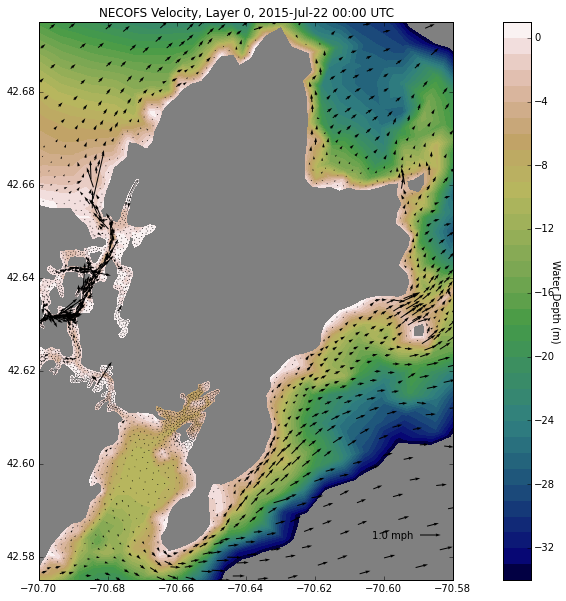

In [35]:
# tricontourf plot of water depth with vectors on top
figure(figsize=(18,10))
subplot(111,aspect=(1.0/cos(mean(lat)*pi/180.0)))
tricontourf(tri, -h,levels=levels,shading='faceted',cmap=plt.cm.gist_earth)
axis(ax)
gca().patch.set_facecolor('0.5')
cbar=colorbar()
cbar.set_label('Water Depth (m)', rotation=-90)
Q = quiver(lonc[idv],latc[idv],2.24*u[idv],2.24*v[idv],scale=20)
maxstr='%3.1f mph' % maxvel
qk = quiverkey(Q,0.92,0.08,maxvel,maxstr,labelpos='W')
title('NECOFS Velocity, Layer %d, %s UTC' % (ilayer, daystr));
figname = r'NECOFS_Velocity'+daystr+'.png'
print figname
savefig('NECOFS_CapeAnn_example.png')

In [36]:
v

array([  1.59098148e-01,   1.43759996e-01,   1.45478204e-01, ...,
         3.55541818e-02,   3.77648622e-02,   7.13085756e-05], dtype=float32)